In [16]:
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount = True)
except:
    pass

In [17]:
import os
try:
    ROOT_PATH = "/content/drive/MyDrive/EE452_2024_Team5_Project/"  # Replace with your directory to A3 folder
    print(os.listdir(ROOT_PATH)) # Check the content of the path
    os.chdir(ROOT_PATH) # cd into directory
    print(os.listdir(".")) # Check the content of current folder
except:
    pass

In [18]:
from src.ngcf import NGCF
import pandas as pd
import torch
import networkx as nx
from sklearn.model_selection import train_test_split

import json
import os
from time import time
from datetime import datetime

from src.ngcf_utils.load_data import Data
from src.ngcf_utils.parser import parse_args
from src.ngcf_utils.helper_functions import early_stopping,\
                                   train,\
                                   split_matrix,\
                                   compute_ndcg_k,\
                                   eval_model,\
                                   probability_matrix
from src.ngcf import NGCF

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2 Positive Interaction Prediction (Neural Graph Collaborative Filtering)

In [19]:
ngcf_link_predictor_folder = "data/ngcf_interaction_predictor/"

In [20]:
!pip install --upgrade wandb

In [21]:
import wandb

try:
    from google.colab import userdata
    wandbkey = userdata.get('WANDB_KEY')
except:
    pass

try:
    wandb.finish()
except:
    pass

try:
    wandb.login(key=wandbkey)
except:
    wandb.login()

### 2a Define train functions

In [22]:
def prep_data(to_reads):
    # load in graph
    if to_reads == True:
        train_graph = nx.read_graphml("data/bipartite_sample_train_wtr.graphml")
        test_graph = nx.read_graphml("data/bipartite_sample_test_wtr.graphml")
    else:
        train_graph = nx.read_graphml("data/bipartite_sample_train.graphml")
        test_graph = nx.read_graphml("data/bipartite_sample_test.graphml")

    combined_graph = nx.compose(train_graph, test_graph)
    # create node name to index mapping
    ## based on codebase for NGCF, indices for both sets start at 0!
    user_nodes = {node for node, node_type in combined_graph.nodes(data=True) if node_type['node_type'] == 'user'}
    book_nodes = {book for book, node_type in combined_graph.nodes(data=True) if node_type['node_type'] == 'book'}
    book_to_idx_map = {node: i for i, node in enumerate(book_nodes)}
    user_to_idx_map = {node: i for i, node in enumerate(user_nodes)}
    with open(ngcf_link_predictor_folder + 'book_to_idx_map.json', 'w') as json_file:
        json.dump(book_to_idx_map, json_file, indent=4)
    with open(ngcf_link_predictor_folder + 'user_to_idx_map.json', 'w') as json_file:
        json.dump(user_to_idx_map, json_file, indent=4)
    user_count = len(user_to_idx_map.keys()) # used in wandb naming below
    book_count = len(book_to_idx_map.keys()) # used in wandb naming below

    # save train and test in format suited for NGCF codebase
    def save_graph_edges_to_txt(G, filename):
        with open(filename, 'w') as file:
            for node, data in G.nodes(data=True):
                if data['node_type'] == 'user':
                    user_node = node # just to make following commands clearer
                    neighbors = list(G.neighbors(user_node))
                    user_node_remapped = user_to_idx_map[user_node]
                    line = f"{user_node_remapped} " + " ".join(map(str, [book_to_idx_map[neighbor] for neighbor in neighbors]))
                    file.write(line + '\n')
    save_graph_edges_to_txt(train_graph, ngcf_link_predictor_folder + "ngcf_train.txt")
    save_graph_edges_to_txt(test_graph, ngcf_link_predictor_folder + "ngcf_test.txt")
    return user_count, book_count, user_to_idx_map, book_to_idx_map

In [23]:
def init_wandb(loss, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs):
    # create model name
    modelname =  "LP_" + \
        "_loss_" + str(loss) + \
        "_tr_" + str(to_reads) + \
        "_pcutoff_" + str(prob_cutoff) + \
        "_poswght_" + str(pos_weight) + \
        "_bs_" + str(batch_size) + \
        "_layers_" + str(layers) + \
        "_nemb_" + str(emb_dim) + \
        "_lr_"  + str(lr) + \
        "_reg_" + str(reg) + \
        "_messdr_" + str(mess_dropout) + \
        "_nodedr_" + str(node_dropout) + \
        "_ucount_" + str(user_count) + \
        "_bcount_" + str(book_count)

    # set wandb init
    wandb.init(
        
        # set the wandb project where this run will be logged
        project="nml_project",

        # name run
        name=modelname,
        
        # track hyperparameters and run metadata
        config={
        "architecture": "NGCF",
        "loss": str(loss),
        "tr": str(to_reads),
        "pcutoff": str(prob_cutoff),
        "batch_size": batch_size,
        "layers": layers,
        "emb_dim": emb_dim,
        "lr": lr,
        "reg": reg,
        "mess_dropout": mess_dropout,
        "node_dropout": node_dropout,
        "user_count": user_count,
        "book_count": book_count,
        "k": k,
        "epochs": n_epochs,
        }
    )

    return modelname

In [24]:
def train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, modelname):
    
    # generate the NGCF-adjacency matrix
    data_generator = Data(path=ngcf_link_predictor_folder, batch_size=batch_size)
    adj_mtx = data_generator.get_adj_mat()

    # create NGCF model
    model = NGCF(user_count, 
                    book_count,
                    emb_dim,
                    layers,
                    reg,
                    node_dropout,
                    mess_dropout,
                    adj_mtx,
                    pos_weight,
                    prob_cutoff,
                    loss_name)
    if use_cuda:
        model = model.cuda()

    # current best metric
    cur_best_metric = 0

    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Set values for early stopping
    cur_best_loss, stopping_step, should_stop = 1e3, 0, False
    today = datetime.now()

    results = {"Epoch": [],
                "Loss": [],
                "Recall": [],
                "NDCG": [],
                "Training Time": []}

    for epoch in range(n_epochs):

        t1 = time()
        loss = train(model, data_generator, optimizer)
        training_time = time()-t1
        print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
            format(epoch, training_time, loss))

        wandb.log({"training_loss": loss})
        
        # print test evaluation metrics every N epochs (provided by eval_N)
        if epoch % eval_N  == (eval_N - 1):
            with torch.no_grad():
                t2 = time()
                recall, ndcg = eval_model(model.u_g_embeddings.detach().to(device),
                                            model.i_g_embeddings.detach().to(device),
                                            data_generator.R_train,
                                            data_generator.R_test,
                                            k,
                                            device)
            #print(
            #    "Evaluate current model:\n",
            #    "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
            #    "Loss: {:.4f}:".format(loss), "\n",
            #    "Recall@{}: {:.4f}".format(k, recall), "\n",
            #    "NDCG@{}: {:.4f}".format(k, ndcg)
            #    )

            cur_best_metric, stopping_step, should_stop = \
            early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)

            # save results in dict
            results['Epoch'].append(epoch)
            results['Loss'].append(loss)
            results['Recall'].append(recall.item())
            results['NDCG'].append(ndcg.item())
            results['Training Time'].append(training_time)

            p_mat, test_recall, test_precision, test_f1_score = probability_matrix(model.u_g_embeddings.detach().to(device),
                                            model.i_g_embeddings.detach().to(device),
                                            data_generator.R_train,
                                            data_generator.R_test,
                                            device)
            
            wandb.log({f"test_recall": test_recall, f"test_precision": test_precision, f"test_f1_score": test_f1_score, f"rec_{k}": recall.item(), f"ndcg_{k}": ndcg.item()})       

        else:
            # save results in dict
            results['Epoch'].append(epoch)
            results['Loss'].append(loss)
            results['Recall'].append(None)
            results['NDCG'].append(None)
            results['Training Time'].append(training_time)

        if should_stop == True: break

    wandb.finish()

    # save
    if save_results:
        date = today.strftime("%d%m%Y_%H%M")

        # save model as .pt file
        if os.path.isdir(ngcf_link_predictor_folder + "/models"):
            torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models" + str(date) + "_" + modelname + ".pt")
        else:
            os.mkdir(ngcf_link_predictor_folder + "/models")
            torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models" + str(date) + "_" + modelname + ".pt")

        # save results as pandas dataframe
        results_df = pd.DataFrame(results)
        results_df.set_index('Epoch', inplace=True)
        if os.path.isdir(ngcf_link_predictor_folder + "/results"):
            results_df.to_csv(ngcf_link_predictor_folder + "/results" + str(date) + "_" + modelname + ".csv")
        else:
            os.mkdir(ngcf_link_predictor_folder + "/results")
            results_df.to_csv(ngcf_link_predictor_folder + "/results" + str(date) + "_" + modelname + ".csv")
        # plot loss
        results_df['Loss'].plot(figsize=(12,8), title='Loss')

### 2b) Train!

#### 2bi) BCE loss, to_reads

In [25]:
# custom
loss_name = 'bce' # 'bpr' or 'bce'
to_reads = True # True or False
prob_cutoff = .90 # threshold above which a positive interaction is predicted to occur
pos_weight = 1 # weight for positive class in BCE loss (helps for imbalanced data). 1 = no reweighting

# standard
batch_size = 16
layers = [16, 32]
emb_dim = 52
lr = 0.015
reg = 0.005
mess_dropout = 0.01
node_dropout = 0.01
k = 20
n_epochs = 40
save_results = True
eval_N = 4 # how often to print eval results

In [26]:
# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

n_users=1000, n_items=500
n_interactions=33787
n_train=23188, n_test=10599, sparsity=0.06757
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.4469785690307617 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1500, 1500) 0.1782395839691162 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...


c:\Users\HP\Documents\GitHub\EE452_2024_Team5_Project\src\ngcf_utils\load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()


Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.043617963790893555 sec.
Initializing weights...
Weights initialized.


100%|██████████| 1450/1450 [02:38<00:00,  9.12it/s]


Epoch: 0, Training time: 159.00s, Loss: 1006.8404
Counter({1.0: 10599})
30744 2723 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [03:05<00:00,  7.82it/s]


Epoch: 1, Training time: 185.33s, Loss: 874.6456
Counter({1.0: 10599})
32040 3124 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [03:00<00:00,  8.01it/s]


Epoch: 2, Training time: 180.93s, Loss: 835.7643
Counter({1.0: 10599})
28714 2956 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [03:17<00:00,  7.34it/s]


Epoch: 3, Training time: 197.46s, Loss: 827.8410
Counter({1.0: 10599})
29580 3112 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [03:05<00:00,  7.83it/s]


Epoch: 4, Training time: 185.12s, Loss: 801.5474
Counter({1.0: 10599})
29548 3233 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


ndcg_20,▁▅▇▇█
rec_20,▁▅▆▇█
test_f1_score,▁▅▅▇█
test_precision,▁▄▆▇█
test_recall,▁▇▄▆█
training_loss,█▃▂▂▁
ndcg_20,0.45055
rec_20,0.2312
test_f1_score,0.16106
test_precision,0.10942
test_recall,0.30503


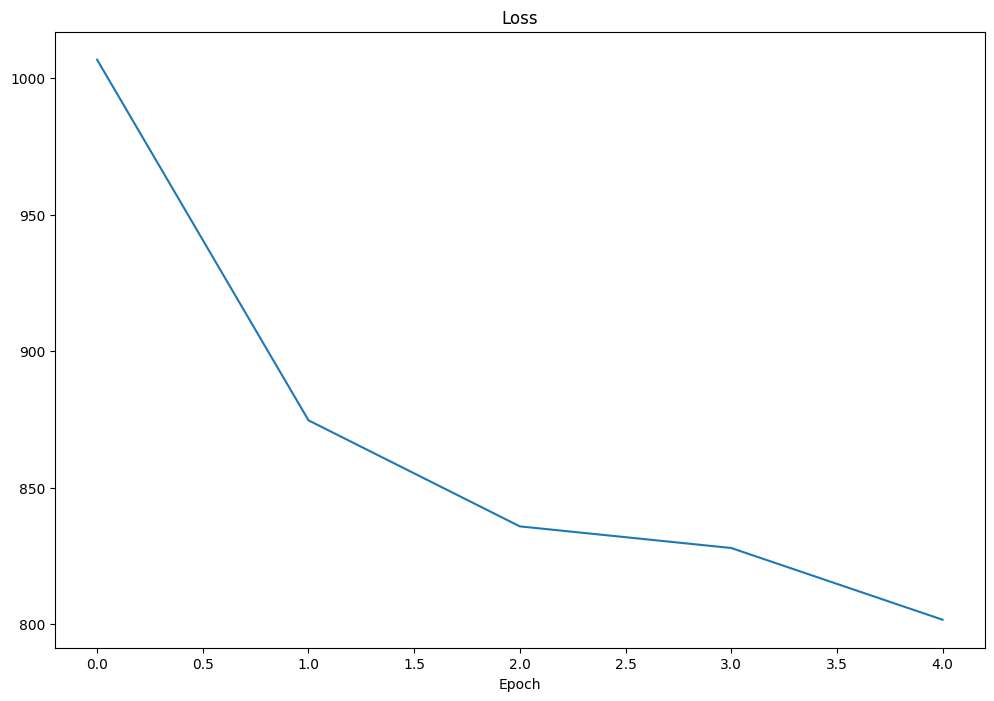

In [28]:
# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2bii) BPR loss, to_reads

In [ ]:
loss_name = 'bpr'

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2biii) BCE loss, no to_reads

In [ ]:
loss_name = 'bce'
to_reads = False

# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2biv) BPR loss, no to_reads

In [ ]:
loss_name = 'bpr'

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)